### Imports and Setup

In [1]:
# Imports
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.vector import dynamicsymbols
from sympy import symbols, cos, sin, diff, sqrt, init_printing, latex, Symbol, Eq, solve, lambdify, print_latex, simplify, cse
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

# Make printouts look nicer
latexReplaceRules = {
    r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}

def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr

init_printing(latex_printer=latexNew)

def pprint_eqn(**kwargs):
    name = list(kwargs.keys())[0]
    return Eq(Symbol(name), kwargs[name], evaluate=False)

Define constants used in the problem

In [2]:
G, M, omega, m, m0, f, a, d, e, tau = symbols(r"G, M, \Omega, m_\oplus, m_0, f, a, d, e \tau", real=True, positive=True)

t=Symbol('t')

Define dynamic variables used in the problem and the Lagrangian

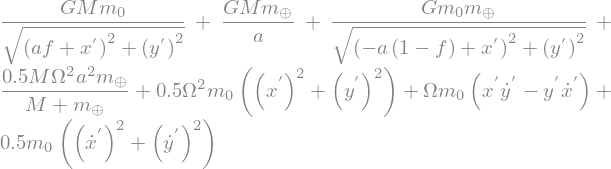

In [3]:
x, y = dynamicsymbols("x^', y^'", real=True)
x_dot = x.diff()
y_dot = y.diff()

L = (1/2) * (M*m)/(M+m) * a**2 * omega**2 + (1/2)*m0*(x_dot**2 + y_dot**2) + (1/2)*m0*omega**2*(x**2+y**2) + m0*omega *(x*y_dot - x_dot*y) + (G*M*m)/a + (G*M*m0)/(sqrt((x+f*a)**2 + y**2)) + (G*m*m0)/(sqrt((x-(1-f)*a)**2 + y**2))
L

Euler Lagrange Equation for x


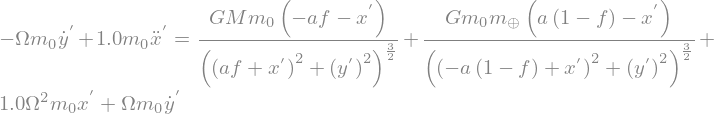

Euler Lagrange Equation for y


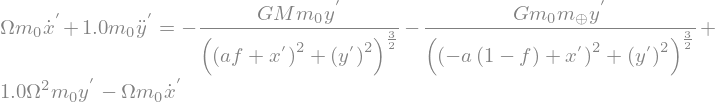

In [4]:
x_derivative = L.diff(x)
x_dot_derivative = L.diff(x_dot) #same as what Prof Tamayo gets!
x_dot_second_derivative = x_dot_derivative.diff(t)

# Euler-Lagrange Equation for x 
ELx = Eq(x_dot_second_derivative, x_derivative)
print("Euler Lagrange Equation for x")
display(ELx)

y_derivative = L.diff(y)
y_dot_derivative = L.diff(y_dot) #same as what Prof Tamayo gets!
y_dot_second_derivative = y_dot_derivative.diff(t)

# Euler-Lagrange Equation for y
ELy = Eq(y_dot_second_derivative, y_derivative)
print("Euler Lagrange Equation for y")
display(ELy)

Equations of motion


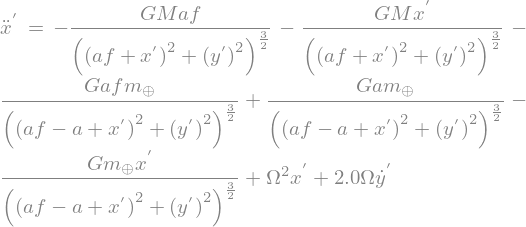

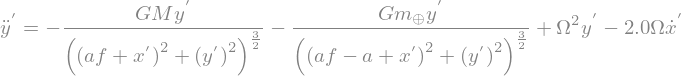

In [5]:
# Isolating x & y double dot
x_doubledot= solve(ELx, x_dot.diff(t))[0] 
y_doubledot= solve(ELy, y_dot.diff(t))[0]

print("Equations of motion")
display(Eq(x_dot.diff(t), x_doubledot))
display(Eq(y_dot.diff(t), y_doubledot))

Now we non-dimensionalize the equations of motion by substituting:
- $x' = X'a$ and $y' = Y'a$
- $\tau = t\Omega$
- $\displaystyle d = \frac{Gm_\oplus}{\Omega^2a^3}$
- $\displaystyle e = \frac{GM}{\Omega^2a^3}$
- $\displaystyle f = \frac{M}{M+m_\oplus}$

Equations of motion


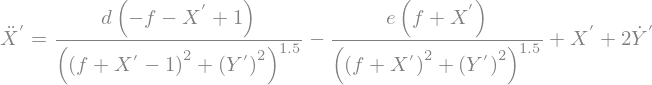

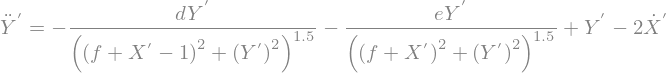

In [6]:
# nondimensionalization
X, Y = dynamicsymbols("X^', Y^'", real=True)
X_dot = X.diff()
Y_dot = Y.diff()

X_doubledot=2*Y.diff() + X +d*(1-X-f)/((f-1+X)**2 +Y**2)**(3/2) -e*(X+f)/((f+X)**2+Y**2)**(3/2)
Y_doubledot=-2*X.diff() + Y -d*Y/((f-1+X)**2 +Y**2)**(3/2) -e*(Y)/((f+X)**2+Y**2)**(3/2)

print("Equations of motion")
display(Eq(X_dot.diff(t), X_doubledot))
display(Eq(Y_dot.diff(t), Y_doubledot))

We can also define the non-dimensionalized hamiltonian as

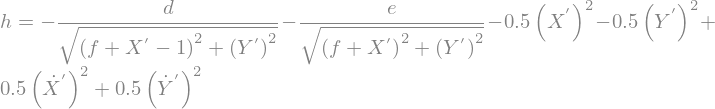

In [7]:
#this is for the nondimensionalized hamiltonian h

h=0.5*(X_dot**2 +Y_dot**2) -0.5*(X**2+Y**2) -e/sqrt((X+f)**2+Y**2) -d/sqrt((X-(1-f))**2+Y**2)

pprint_eqn(h=h)

For future use, we will want to be able to recover the true system parameters from the non-dimensionalized quantities

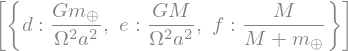

In [8]:
# solve([Eq(f, M/(M+m)), Eq(d, G*m/(omega*a)**2), Eq(e, G*M/(omega*a)**2)])
solve([Eq(f, M/(M+m)), Eq(d, G*m/(omega*a)**2), Eq(e, G*M/(omega*a)**2)], implicit=True, manual=True)

In [9]:
# lambdify, give eq in terms of variables, gives its inputs, then lets you input the inputs in the expression. So turn symbolic math into python function 


gx = lambdify((X, Y, Y_dot, d, e, f), X_doubledot, 'numpy') #Before, python solved for X dot dot and Y dot dot. So, this puts that as a function, so we can use it later for our DE. 
fy = lambdify([X, X_dot, Y, d, e, f], Y_doubledot, 'numpy')

H = lambdify([X, X_dot, Y, Y_dot, d, e, f], h, 'numpy') #took away m0 bc not hamiltonian...

def three_body_prob(tau, Z, d, e, f): #Not sure why we need it, but I added tau back in.
    X, w, Y, z = Z #separates Z into 4 variables, corresponding to X, X dot, Y, Y dot. So...I guess Z is supposed to be a list? 

    X_dot = w
    Y_dot = z
    w_dot = gx(X, Y, Y_dot, d, e, f)
    z_dot = fy(X, X_dot, Y, d, e, f)

    return X_dot, w_dot, Y_dot, z_dot

def get_solution(diffeq, initial_conditions, tstart=None, tend=None, pts=1000, t=None, **kwargs):
    if t is None:
        t = np.linspace(tstart, tend, int(pts))

    # return odeint(diffeq, initial_conditions, t, args=params, **kwargs).T
    return solve_ivp(diffeq, (np.min(t), np.max(t)), initial_conditions, t_eval=t, **kwargs)

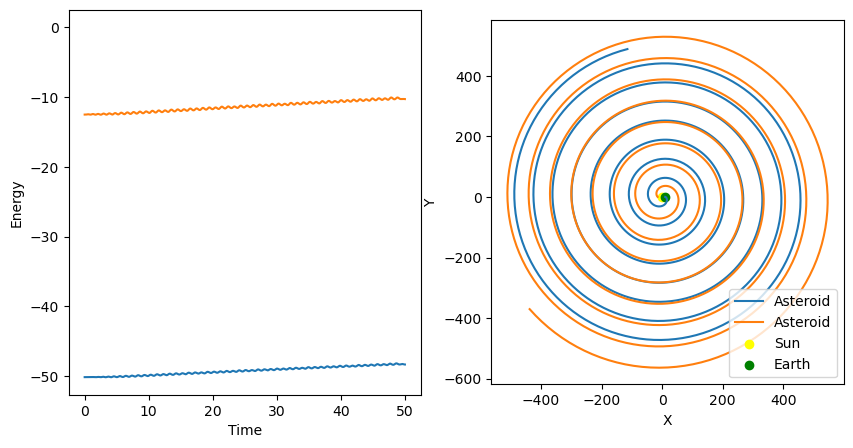

In [23]:
#solving the differential equation
fig, axs = plt.subplots(1, 2, figsize=(10,5))

initial_conditions = [
    (10.01, 0, 0, 0),
    (-15, -10, 0, 10)
] # X initial, X dot initial, Y initial, Y dot initial
args = (0.01666, 0.1666, 0.0909) #this is just d, e, f, so we can insert this into three_body_prob. 

for ic in initial_conditions:
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=50)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    axs[0].plot(t_eval, H(xa, wa, ya, za, *args))
    axs[1].plot(xa, ya, label="Asteroid")

axs[0].scatter(0,0, c='white') # force x = 0 to be included
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Energy")

axs[1].scatter(0, 0, label="Sun", c='yellow')
axs[1].scatter(10, 0, label="Earth", c='green')
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_aspect(1)
axs[1].legend()

To generate surfaces of section, we need to pick a degree of freedom and value to slice along, we have chose $X=0$ because that is when the mass $m_0$ crosses the line formed by $M$ and $m_\oplus$

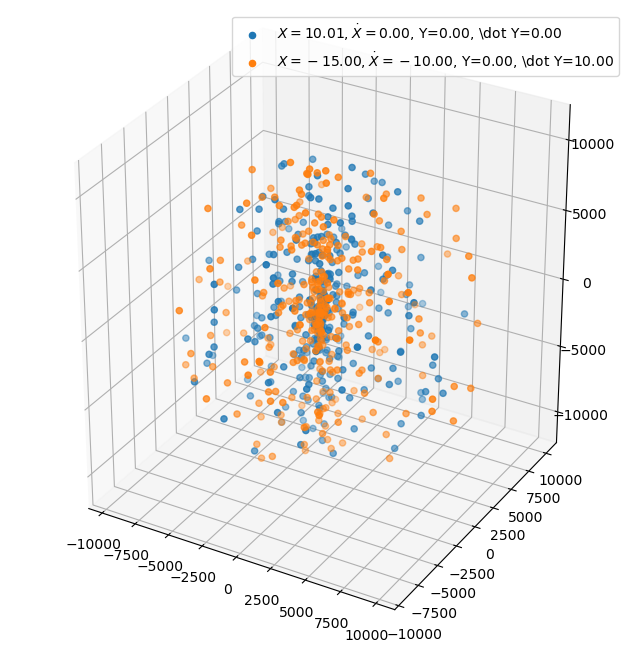

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

initial_conditions = [
    (10.01, 0, 0, 0),
    (-15, -10, 0, 10)
] # X initial, X dot initial, Y initial, Y dot initial
args = (0.01666, 0.1666, 0.0909) #this is just d, e, f, so we can insert this into three_body_prob. 

for ic in initial_conditions:
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=1000, pts=100000)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    idxs = []
    xa_mod = -np.abs(xa)
    for i in range(1, len(xa)-1):
        if xa_mod[i - 1] < xa_mod[i] > xa_mod[i + 1]:
            idxs.append(i)

    r = wa[idxs]
    theta = ya[idxs]
    phi = za[idxs]

    ax.scatter(
        r*np.sin(phi)*np.cos(theta),
        r*np.sin(phi)*np.sin(theta),
        r*np.cos(phi),
        label=f'$X={ic[0]:.2f}, \\dot X={ic[1]:.2f}$, Y={ic[2]:.2f}, \\dot Y={ic[3]:.2f}',
        # alpha=0.1
    )

ax.legend()
ax.set_aspect('equal')
plt.show()